[![Open in colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/nunososorio/bhs/blob/main/Data_structures/NB2_Intro_scanpy.ipynb)

# Notebook 2 - [AnnData](https://anndata.readthedocs.io/en/latest/) and [Scanpy](https://scanpy.readthedocs.io/en/stable/)
In this notebook we will explore the Annotated Data (AnnData) data structure and the [Scanpy](https://scanpy.readthedocs.io/en/stable/) library.

This data structure is meant to allow you to keep (biological) data together with annotations about its observations (patients/cells/tumors...) and its variables

# Setup the environment

The *basic* libraries (Numpy, Pandas, Matplotlib, Seaborn...) are already installed in Google Colab. To run this notebook you will need to install scanpy and anndata

In [ ]:
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install scanpy anndata

In [69]:
# Import all the libraries we will use
import os
import numpy as np
from scipy.stats import ttest_ind
from scipy.stats import wilcoxon
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import anndata
import random
import scanpy as sc

In [ ]:
# Some details for the plots
plt.rcParams.update({'font.size':18, 'figure.figsize':(8,8)})

# Load some data

We will use the simulated data we generated previously. If you didn't sotre you can just get from the course repository.



In [ ]:
if not os.path.exists('My_data.csv'):
    !wget https://raw.githubusercontent.com/Leo-GG/bhs/main/Data_structures/My_data.csv

--2024-02-10 12:09:06--  https://raw.githubusercontent.com/Leo-GG/bhs/main/Data_structures/My_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154509 (151K) [text/plain]
Saving to: ‘My_data.csv’

My_data.csv         100%[===================>] 150.89K  --.-KB/s    in 0.02s   

2024-02-10 12:09:06 (6.30 MB/s) - ‘My_data.csv’ saved [154509/154509]



In [ ]:
df=pd.read_csv('My_data.csv',index_col=0)

If you remember, this data was a table where we had stored:
1. One row per observation
2. One column per "gene", with a numerical value for each observation
3. One column with an attribute of of the observations (diseased -D- or healthy -H-)

In [ ]:
# Have a look and see that it looks alright
df.head(5)

,STATA,PORTX,RCDLPE,SOLB,ARTQ-1,TP53-2,OLIG1E,RCDLP-2,EGFRE,TP53B,...,MYCE,PORTF,PORTA,RCDLPD,MAPKA,RCDLPA,PORTD,STATB,STATE,Condition
0,0.906096,0.289966,0.922735,0.346983,0.577251,0.322441,0.606386,0.866573,0.744390,0.868533,...,0.672226,0.573145,0.958392,0.676073,0.462082,0.665234,0.481882,0.684159,0.780679,D
1,0.901538,0.218195,0.192716,0.024868,0.481387,0.498697,0.543510,0.845710,0.678769,0.727027,...,0.976958,0.510887,0.534209,0.683735,0.765026,0.580489,0.585316,0.721164,0.748842,D
2,0.128673,0.118117,0.318138,0.543093,0.946080,0.039307,0.723749,0.575219,0.458111,0.537061,...,0.154411,0.428856,0.227768,0.639436,0.880609,0.270456,0.154815,0.978593,0.582099,H
3,0.732315,0.651810,0.412433,0.743514,0.289821,0.849638,0.377588,0.249050,0.697354,0.588791,...,0.159748,0.210486,0.625764,0.505561,0.675746,0.166252,0.407812,0.536100,0.118613,H
4,0.481497,0.104489,0.628645,0.769691,0.226612,0.623943,0.514755,0.393568,0.452407,0.088314,...,0.501525,0.201361,0.948299,0.471847,0.115893,0.378326,0.404491,0.479998,0.288962,H


In [ ]:
# Like before, we should have 100 observations and 81 columns/variables
df.shape

(100, 81)

# From DataFrame to Anndata

The anndata library supports the use of Annotated Data (AnnData) objects. In these objects
- The numerical data is kept in a main matrix (X)
- Annotations about the observations and the variables are kept in accesory tables, names "obs" and "var"
<br/><br/>
<br/><br/>

<img src="https://falexwolf.de/img/scanpy/anndata.svg" alt="AnnData" style="width:600px; height:auto;"/>





<br/><br/>
We will build an AnnData object using our table:
- The "gene" data will go on the X matrix
- The information we have about the Condition will go to the "obs" DataFrame
- The "gene" names will go to the "var" DataFrame






In [21]:
# First we create the object using the table, keeping all the columns except the last one
adata=anndata.AnnData(X=df.iloc[:,:-1].copy())
adata


/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 100 × 80

In [22]:
# Then we copy the Condition to the "obs" DataFrame
adata.obs=df[['Condition']].copy()
adata

/usr/local/lib/python3.10/dist-packages/anndata/_core/anndata.py:859: UserWarning: 
AnnData expects .obs.index to contain strings, but got values like:
    [0, 1, 2, 3, 4]

    Inferred to be: integer

  value_idx = self._prep_dim_index(value.index, attr)


AnnData object with n_obs × n_vars = 100 × 80
    obs: 'Condition'

In [23]:
# Let's read the warning and fix the issue...
adata.obs.index=adata.obs.index.astype(str)
adata

AnnData object with n_obs × n_vars = 100 × 80
    obs: 'Condition'

## Let's check each element of our AnnData object

In [28]:
adata.X

array([[0.90609638, 0.28996631, 0.92273549, ..., 0.48188219, 0.68415883,
        0.78067925],
       [0.90153824, 0.21819457, 0.19271573, ..., 0.58531635, 0.72116356,
        0.74884186],
       [0.12867303, 0.11811667, 0.31813841, ..., 0.15481523, 0.97859311,
        0.58209919],
       ...,
       [0.79825899, 0.13792066, 0.35338025, ..., 0.71790813, 0.43312837,
        0.90829586],
       [0.35261516, 0.69451313, 0.00787829, ..., 0.81029893, 0.05364248,
        0.88581211],
       [0.35807807, 0.40408302, 0.66957712, ..., 0.20049846, 0.34831957,
        0.16315125]])

In [26]:
adata.obs.head(3)

,Condition
0,D
1,D
2,H


In [27]:
# The "var" DataFrame will be empty for now, but we can check that its index is made of "gene" names
adata.var.head(3)

""
STATA
PORTX
RCDLPE


# OK, but why?

## 1. Efficient data storage
One very important feature of the AnnData object is that it separates numerical values from annotations

The numerical data stored in the X matrix can now be stored using memory-efficient formats, such as sparse matrices

This makes possible to store and access *very* large datasets

## 2. Annotations

Now we can add all the information we want about the observations/subjects/samples and about the features!

Categorical and strings do not get mixed up with the numerical values on the matrix

In [29]:
# Maybe we want to include the age of our subjects
adata.obs['Age']=[ random.randint(20, 100) for i in range(adata.n_obs)]

# Add their sex
adata.obs['Sex']=np.random.choice(['F','M'],adata.n_obs)

# And some other variable
adata.obs['Hospitalized']=np.random.choice(['Y','N'],adata.n_obs)

In [32]:
adata.obs.head(3)

,Condition,Age,Sex,Hospitalized
0,D,35,M,Y
1,D,51,F,Y
2,H,92,M,Y


In [35]:
# Same with the genes, we can add some annotations to them
# Describe what the variable represents
adata.var['Type']='Not-a-real-gene'

# Add a random clinical annotation
adata.var['Clinical_annotation']=np.random.choice(['Pathogenic','NA','Unknown','Developmental'],adata.n_vars)

In [36]:
adata.var.head(3)

,Type,Clinical_annotation
STATA,Not-a-real-gene,Unknown
PORTX,Not-a-real-gene,Pathogenic
RCDLPE,Not-a-real-gene,Unknown


In [37]:
# Now the AnnData object is storing all the information in a single object
adata

AnnData object with n_obs × n_vars = 100 × 80
    obs: 'Condition', 'Age', 'Sex', 'Hospitalized'
    var: 'Type', 'Clinical_annotation'


### We have now a rather complex object!
We have
- High-dimensional biological data
- Information about our observations
- Information about the variables

All in one place!

## 3. Data analysis!

The [scanpy](https://scanpy.readthedocs.io/en/stable/) library, designed for single-cell data analysis, offers *many* methods that can be used with data stored in AnnData objects

<br/><br/>

<img src="https://scanpy.readthedocs.io/en/stable/_static/Scanpy_Logo_BrightFG.svg" alt="AnnData" style="width:100px; height:auto;"/>

<br/><br/>


### Plotting
Scanpy has great plotting functions!
You can plot your data referring to any of the annotations stored in ".var" or in ".obs"

In [43]:
# For example, lets pick some genes to plot
adata.var.iloc[[3,8,22, 54, 12]]

,Type,Clinical_annotation
SOLB,Not-a-real-gene,Developmental
EGFRE,Not-a-real-gene,Pathogenic
MTE,Not-a-real-gene,Pathogenic
PORT_NC,Not-a-real-gene,Unknown
TACD,Not-a-real-gene,NA


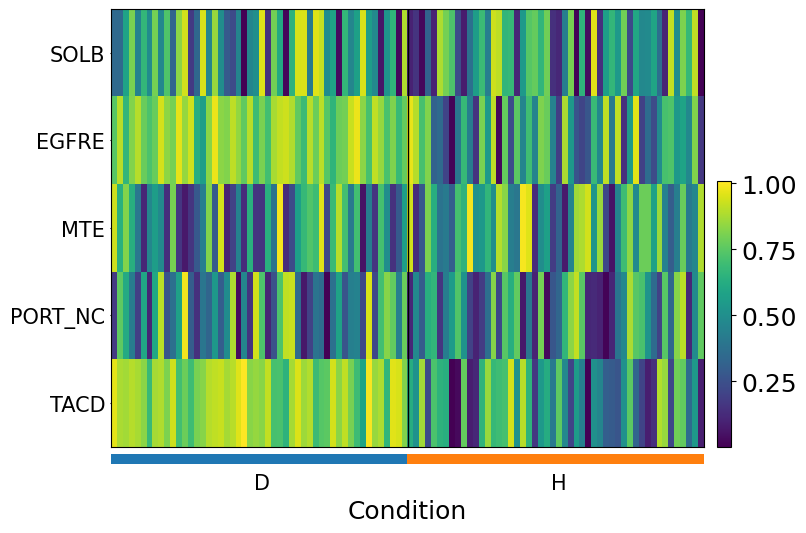

In [44]:
# Now let's use scanpy to plot their values on each of the two condition groups

sc.pl.heatmap(adata=adata, var_names=['SOLB','EGFRE','MTE','PORT_NC','TACD'], groupby='Condition', swap_axes=True,figsize=[8,6])

### Statistical tests
Scanpy has functions to easily compare groups of observations


In [45]:
# For example rank_genes_groups() allows you make comparisons between groups of observations

sc.tl.rank_genes_groups(adata=adata, groupby='Condition', method='wilcoxon')

In [46]:
# The results are stored in the "unstructured" (uns) layer

adata

AnnData object with n_obs × n_vars = 100 × 80
    obs: 'Condition', 'Age', 'Sex', 'Hospitalized'
    var: 'Type', 'Clinical_annotation'
    uns: 'Condition_colors', 'rank_genes_groups'

In [ ]:
adata.uns['rank_genes_groups']

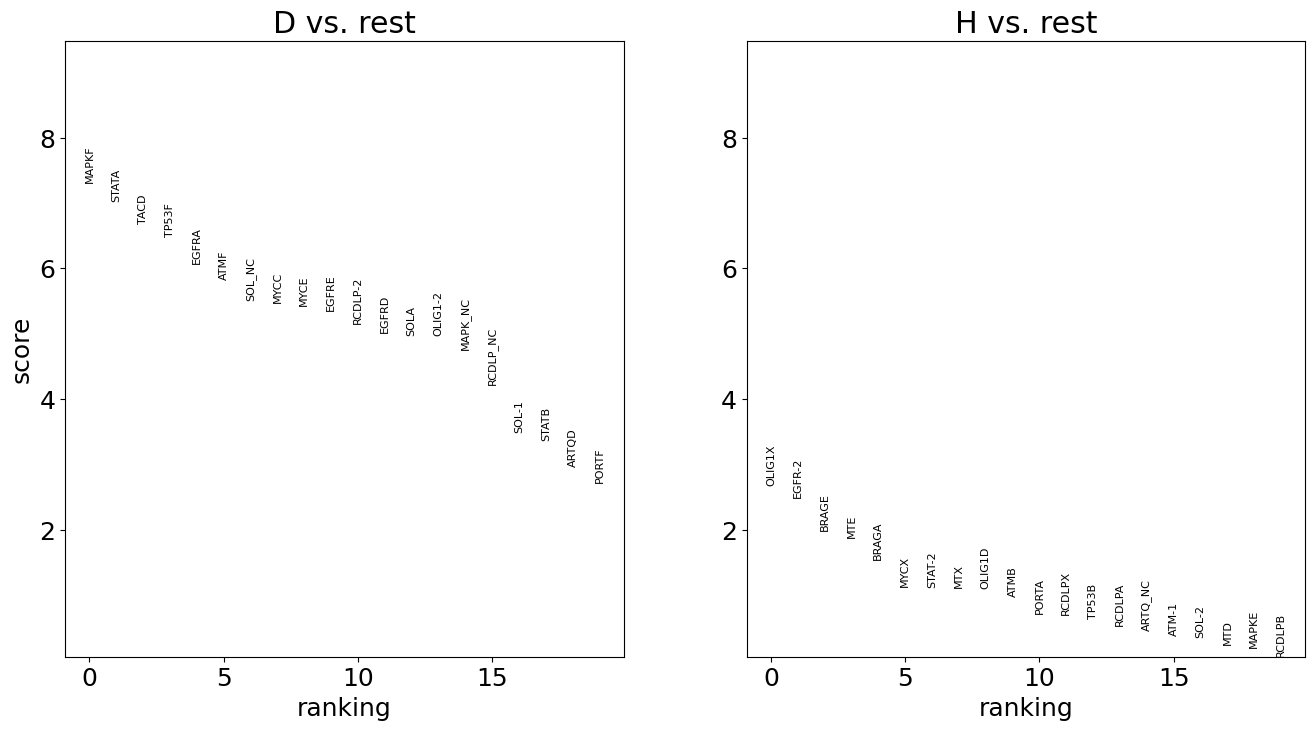

In [48]:
# We can use these results to plot the features that are more different on each group
sc.pl.rank_genes_groups(adata)

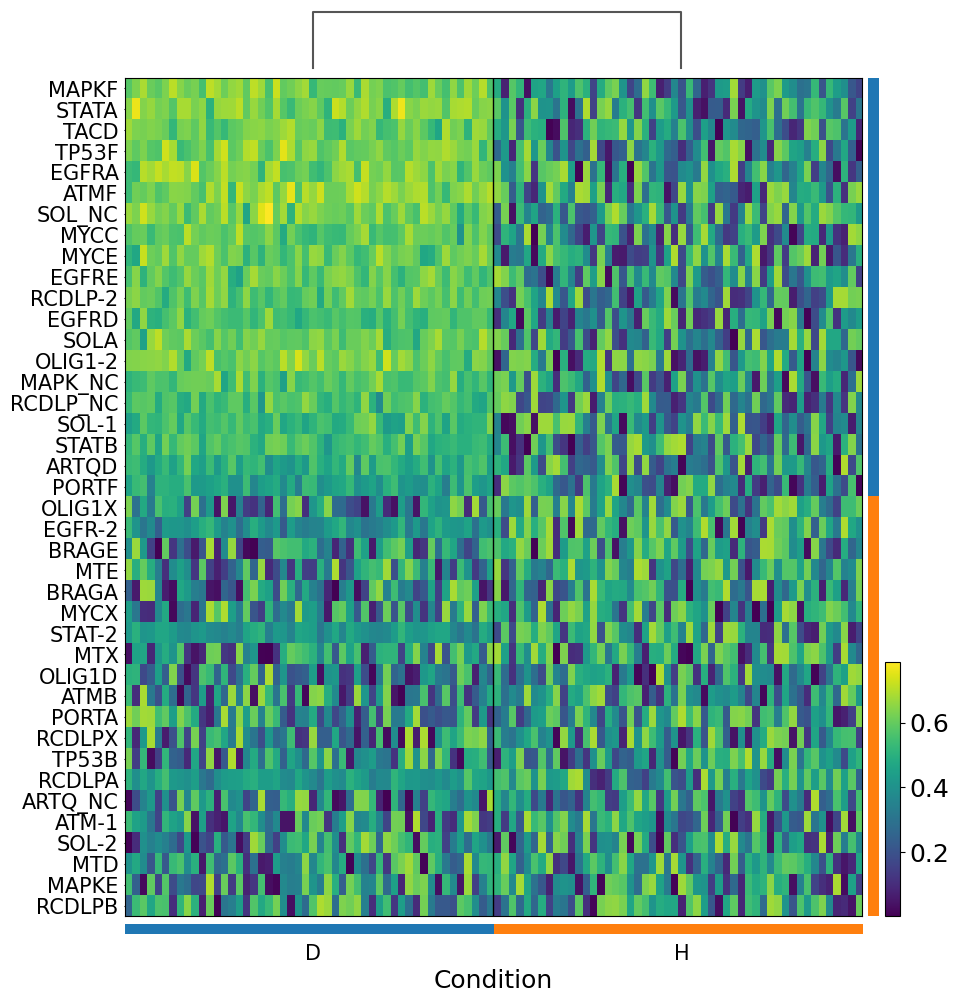

In [70]:
# We can plot the actual values of the top-ranking variables - i.e. the ones with most differences across groups

sc.pl.rank_genes_groups_heatmap(adata,n_genes=20,groupby='Condition',swap_axes=True,figsize=[10,12])

In [50]:
# It also allows you to operate on your data, e.g. log-transforming it

sc.pp.log1p(adata)


### Feature selection
Scanpy allows you to **easily** do a simple feature selection:
the highly_variable_genes() function uses different methods to label variables as "highly variable" or not, based on their values across the dataset
<br/><br/>

In [54]:
# Let's label our "genes"

sc.pp.highly_variable_genes(adata,min_disp=0)


,Type,Clinical_annotation,highly_variable,means,dispersions,dispersions_norm
STATA,Not-a-real-gene,Unknown,True,0.535381,-2.160095,1.000000
PORTX,Not-a-real-gene,Pathogenic,True,0.424415,-1.924401,0.196765
RCDLPE,Not-a-real-gene,Unknown,False,0.386320,-1.762444,-0.163878
SOLB,Not-a-real-gene,Developmental,True,0.419473,-1.821291,0.591583
ARTQ-1,Not-a-real-gene,NA,True,0.408880,-1.706482,0.885274
...,...,...,...,...,...,...
MAPKA,Not-a-real-gene,NA,True,0.456708,-2.194055,0.707107
RCDLPA,Not-a-real-gene,Unknown,False,0.430855,-2.654507,-1.510226
PORTD,Not-a-real-gene,Developmental,True,0.398263,-1.788216,0.434400
STATB,Not-a-real-gene,Developmental,True,0.476323,-2.194896,0.707107


In [ ]:
adata.var

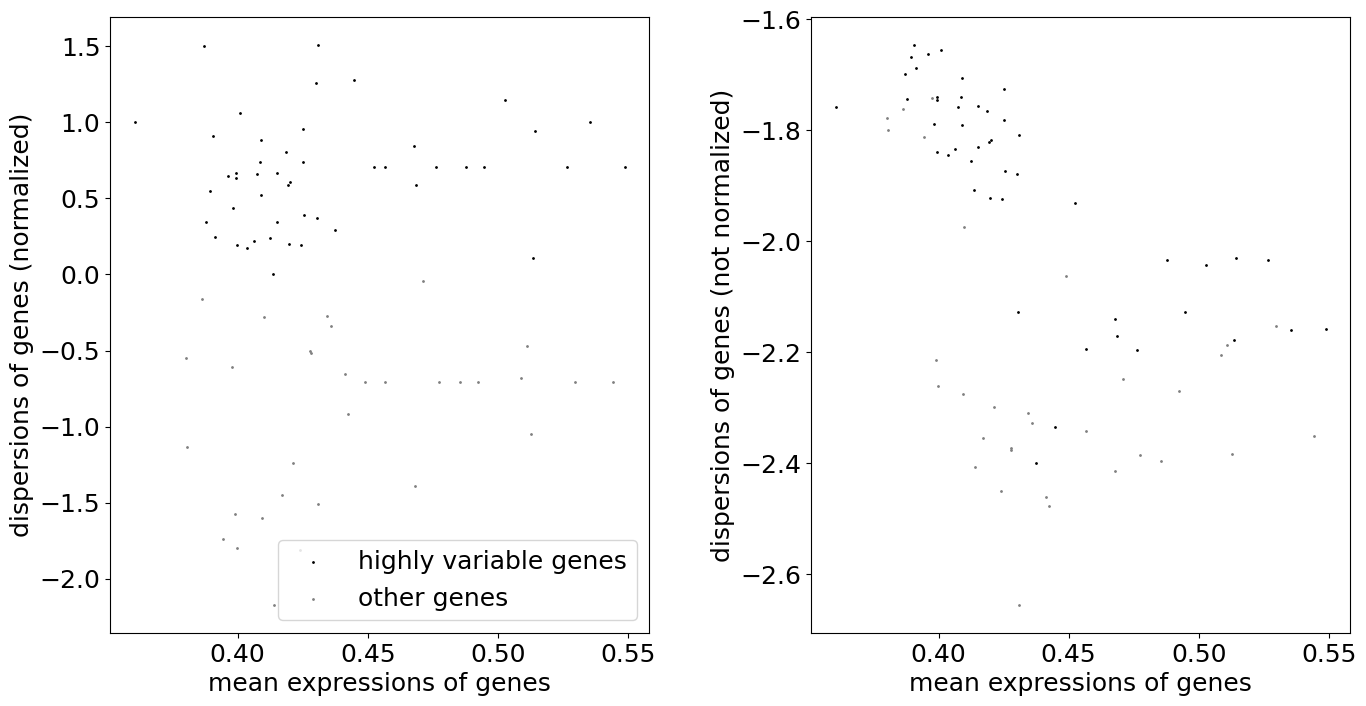

In [53]:
# You directly call a function to visualize the results of this function

sc.pl.highly_variable_genes(adata=adata)

### Dimensionality reduction

Scanpy was designed to work with single-cell sequencing data. In this type of data, each observation is described by thousands of variables.

A very useful/important step in the analysis of **highly-dimensional** data is dimensionality reduction. These are techniques that reflect the information across all variables in fewer dimensions.

For example, this allows us to make 2d or 3d visualizations of our 80-gene data


In [55]:
# You can apply PCA with a single function call
sc.pp.pca(adata, n_comps=20, use_highly_variable=True)

# Results are stored in the varm and obsm layers
adata

AnnData object with n_obs × n_vars = 100 × 80
    obs: 'Condition', 'Age', 'Sex', 'Hospitalized'
    var: 'Type', 'Clinical_annotation', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Condition_colors', 'rank_genes_groups', 'dendrogram_Condition', 'log1p', 'hvg', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'

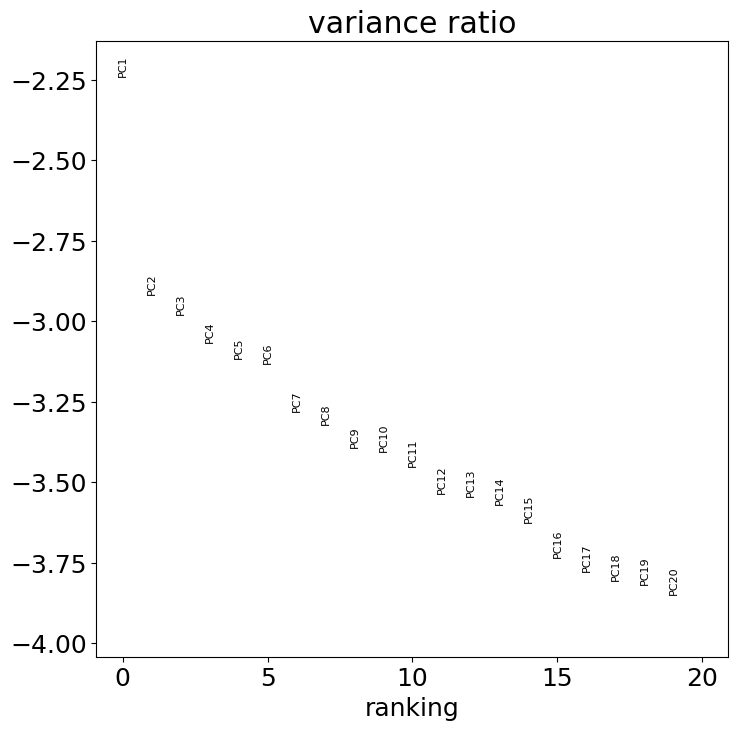

In [56]:
# Visualize the PCA loadings
sc.pl.pca_variance_ratio(adata, log=True, n_pcs=20)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


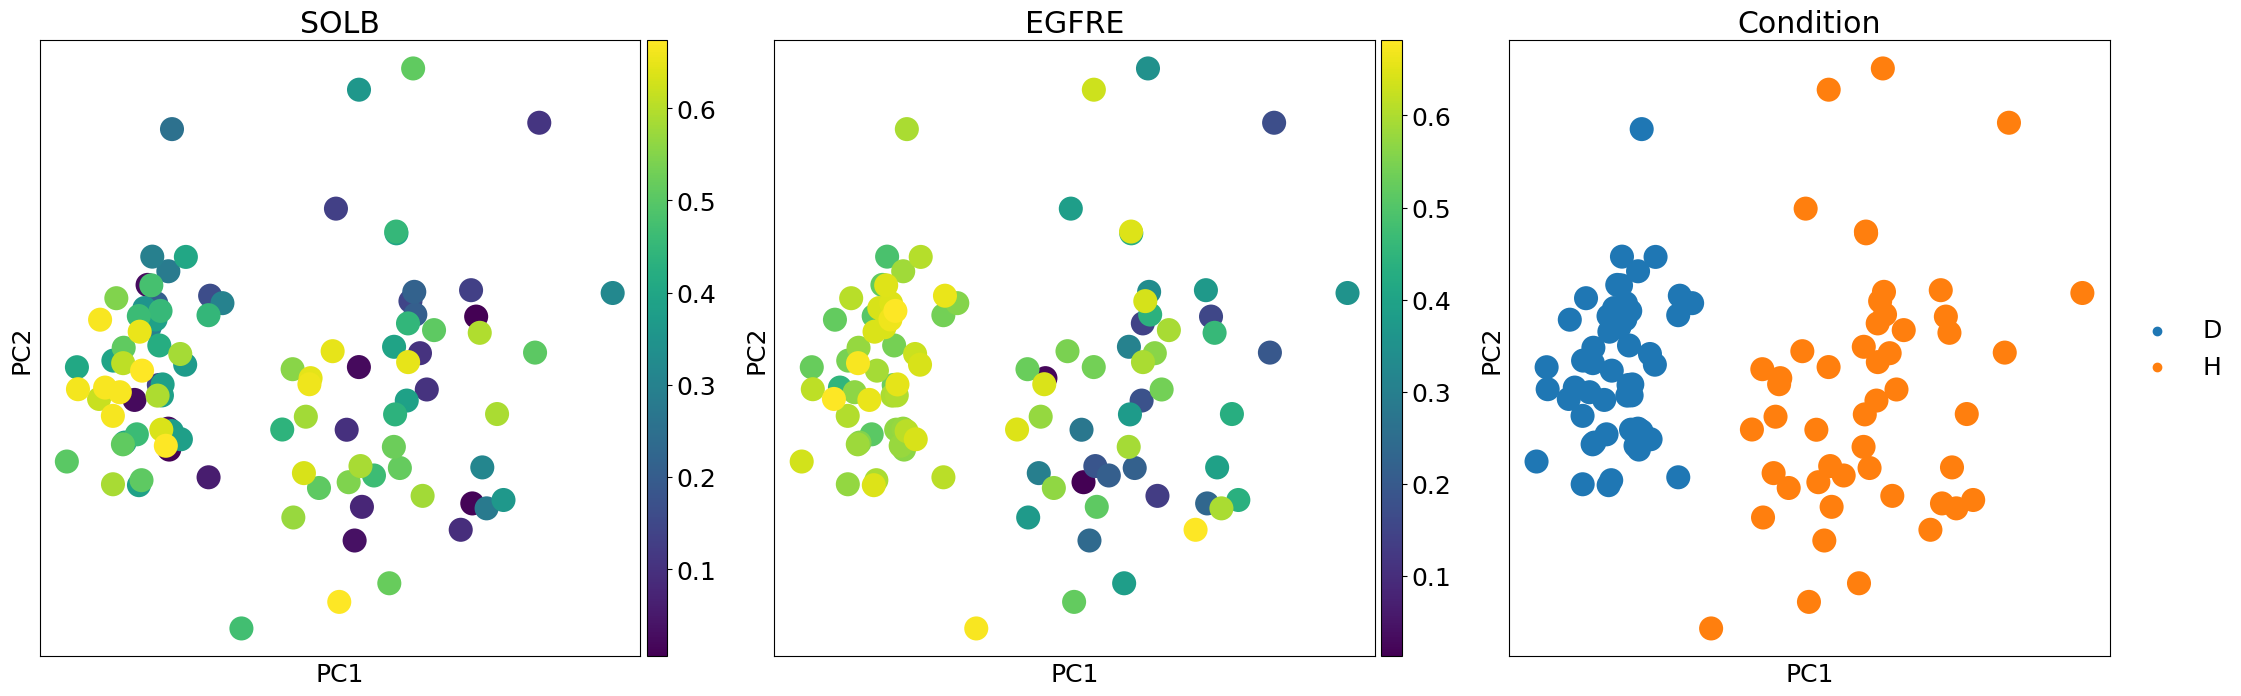

In [57]:
# Visualize the data projected on the PCs, color by variable or observation attribute
sc.pl.pca(adata=adata, color=['SOLB','EGFRE','Condition'])

# You are not bound to Scanpy!

Remember that the AnnData object is still "just" a collection of data entries: a central matrix connected to dataframes with annotations

You can read, write and transform this data using any library with tools specific to your problem


In [65]:
# For example, let's use sklearn to cluster the data and write the results back the anndata object

# First import a clustering tool from sklearn
from sklearn.cluster import KMeans
# Instantiate it
kmeans = KMeans(n_clusters=4, random_state=42)

# Then we apply it to our data
adata.obs['kmeans_cluster'] = kmeans.fit_predict(adata.X)


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [66]:
adata.obs

,Condition,Age,Sex,Hospitalized,kmeans_data
0,D,35,M,Y,3
1,D,51,F,Y,3
2,H,92,M,Y,0
3,H,76,F,N,3
4,H,69,F,Y,0
...,...,...,...,...,...
95,D,21,F,N,3
96,D,73,F,N,3
97,H,89,M,N,0
98,H,29,F,Y,2


In [67]:
# Make sure the results are kept as categories and not numbers, so the plots will be easier to understand
adata.obs['kmeans_data']=adata.obs['kmeans_data'].astype('category')

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


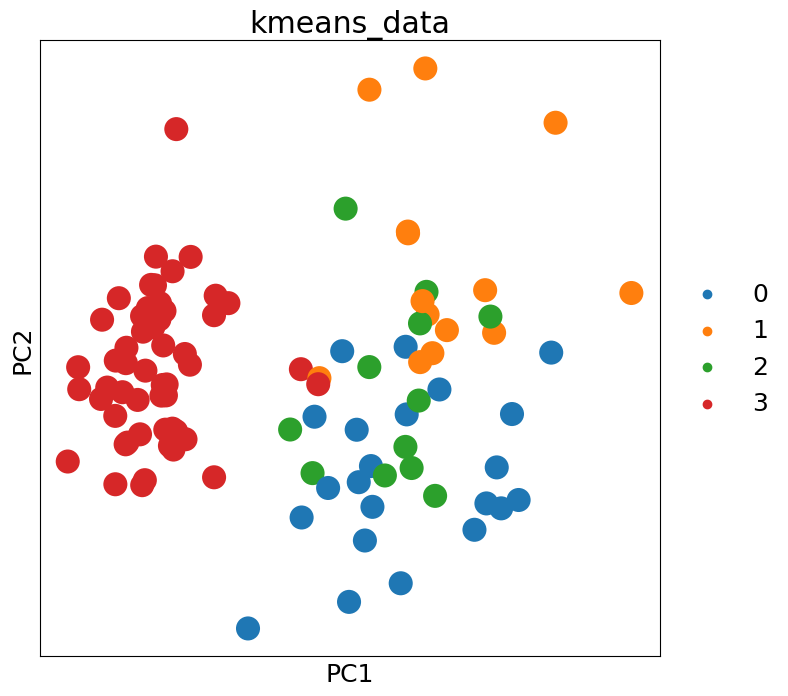

In [68]:
# Now let's use again the scanpy function to visualize the results on the PCA space
sc.pl.pca(adata, color=['kmeans_clusters'])

### Cluster on the PCA space instead...if we have time

In [ ]:
# Cluster the data again, but use the first 2 principal components only
adata.obsm['X_pca'].shape # The PCA data is stored here, it is n_obs x the number of PCs that we calculated

(100, 20)

In [ ]:
# The first 2 PCs are the first 2 columns
adata.obsm['X_pca'][:,0:2]

# We can use k-means again
adata.obs['kmeans_PCA'] = kmeans.fit_predict(adata.obsm['X_pca'][:,0:2])

/Users/lgarma/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


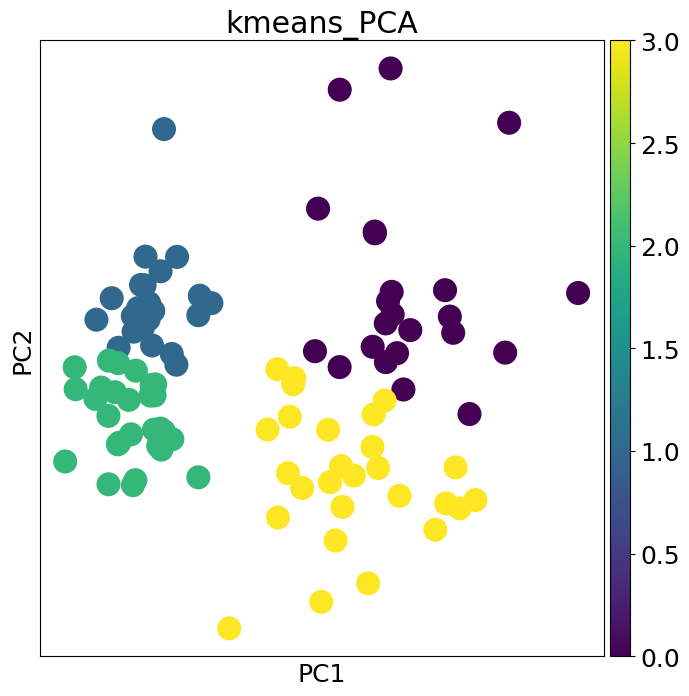

In [ ]:
# See the results
sc.pl.pca(adata, color=['kmeans_PCA'])

# Into the multi-ome: tables of tables

Current *-omics* techniques tend more and more to be run in parallel, so we can have information on different **modalities** for the same subjects/cells/tissue...

For example, you we can have RNA-sequencing data and proteomics data. In our example, we would have two data tables and one table with subject information/metadata.

<img src="https://github.com/Leo-GG/bhs/blob/main/Data_structures/Illustrations/premise3.png?raw=true" alt="AnnData" style="width:100px; height:auto;"/>

<br/><br/>


**Luckily** for us, there is a Python library designed for multiomics data: [Muon](https://muon.readthedocs.io/en/latest/)


<img src="https://github.com/scverse/muon/raw/master/docs/img/muon_header.png" alt="AnnData" style="width:100px; height:auto;"/>

<br/><br/>




In Muon we basically pile up multiple AnnData objects, one for each **modality**, and we keep sets of annotations that are common to the observations (subjects/cells..) in all modalities

<img src="https://github.com/Leo-GG/bhs/blob/main/Data_structures/Illustrations/muon_paper.png?raw=true" alt="AnnData" style="width:100px; height:auto;"/>
source: Bredikhin et al. "MUON: multimodal omics analysis framework", Genome Biology (2022)
<br/><br/>

<img src="https://github.com/Leo-GG/bhs/blob/main/Data_structures/Illustrations/muon_diagram.png?raw=true" alt="AnnData" style="width:100px; height:auto;"/>
<br/><br/>

The main advantage of the Muon framework is that allows the use of **multimodal integration** methods: [MOFA](https://biofam.github.io/MOFA2/)

<br/><br/>


<img src="https://biofam.github.io/MOFA2/images/mofa_overview.png" alt="AnnData" style="width:100px; height:auto;"/>
<br/><br/>

But that's a topic for another time...
<br/><br/>